In [6]:
import numpy as np
import pandas as pd
import pyro.distributions as dist
from scipy import stats
import torch
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

import copy
import json

import argparse

import sys
import os
from utils_functions import *
import model_mobster_gmm as mobster_mv

# Set the parent directory
parent_dir = "../../"
sys.path.insert(0, parent_dir)
# import new_model as mobster_mv
from utils.BoundedPareto import BoundedPareto
from utils.create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def plot_scatter_real_here(NV, DP, N, K, D, type_labels_cluster, cluster_labels, idx_real, purity, coverage):
    pairs = np.triu_indices(D, k=1)  # Generate all unique pairs of samples (i, j)
    vaf = NV/DP    
    num_pairs = len(pairs[0])  # Number of unique pairs
    ncols = min(3, num_pairs)
    nrows = (num_pairs + ncols - 1) // ncols  # Calculate the number of rows

    fig_width_per_plot = 5
    fig_width = ncols * fig_width_per_plot
    fig_height = 5 * nrows

    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
    if num_pairs == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    idx = 0
    for i, j in zip(*pairs):
        ax = axes[idx]  # Select the appropriate subplot
        x = vaf[:, i].numpy()
        y = vaf[:, j].numpy()

        for c, cluster in enumerate(np.unique(cluster_labels)):
            mask = (cluster_labels == cluster)  # Mask for current cluster
            ax.scatter(x[mask], 
                        y[mask],
                        label=f'{cluster.astype("int")} {type_labels_cluster[c].tolist()}', s = 10)
        ax.legend(loc='best')
        ax.set_title(f'Sample {i+1} vs Sample {j+1}')
        ax.set_xlabel(f'Sample {i+1}')
        ax.set_ylabel(f'Sample {j+1}')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        idx += 1
    plt.suptitle(f'Orignal data with N = {N} and {K} clusters (i = {idx_real})')
    plt.show()
    # plt.savefig(f'plots/p_{str(purity).replace(".", "")}_cov_{coverage}/D_{D}/real/N_{N}_K_{K}_D_{D}_real_{idx_real}.png')
    plt.close()

tensor([0.2177, 0.1675, 0.2208, 0.1033, 0.1553, 0.1354])
tensor([2177.3945, 1674.7606, 2207.7388, 1033.0123, 1553.4269, 1353.6667])
np.sum(pi) 10000


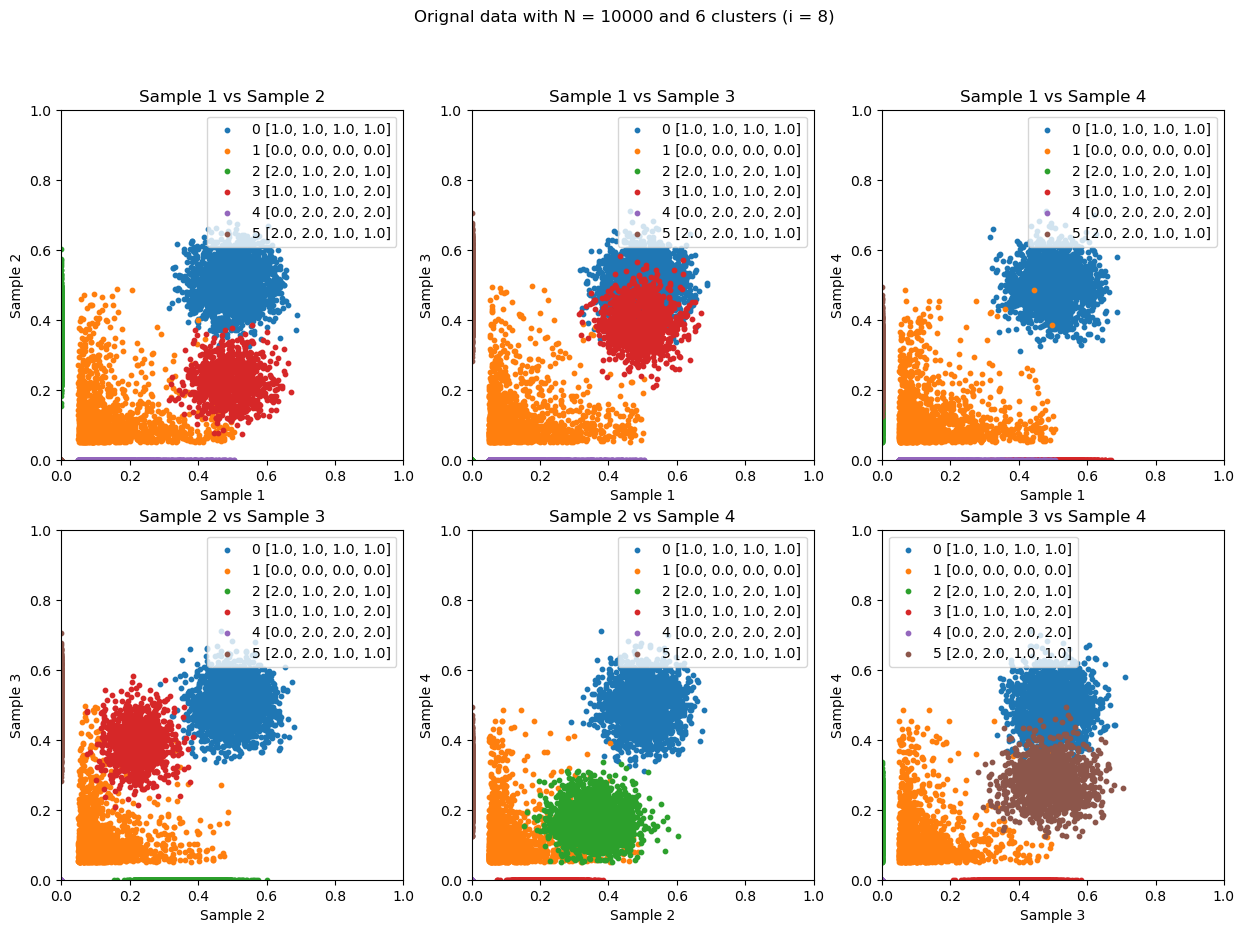

In [8]:
num_iter = 2000
num_dataset = 15

N = 10000  # number of mutations
K = 6  # number of clusters
D = 4  # number of samples
purity = 1
coverage = 100

# create_folder(N,K,D,purity,coverage)

seed = 0
idx = 8
seed1 = seed+idx+K+N
pyro.set_rng_seed(seed1)
torch.manual_seed(seed1)
np.random.seed(seed1)

# Sample mixing proportions for clusters and multiply by N to obtain the number of data in each cluster
pi = sample_mixing_prop(K, min_value=0.05) * N
print(pi/N)
print(pi)
# pi = dist.Dirichlet(torch.ones(K)).sample() * N  # Number of data in each cluster
pi = np.round(pi.numpy()).astype('int')

# Adjust proportions to ensure they sum to N
print("np.sum(pi)", np.sum(pi))
if np.sum(pi) < N:
    diff = N - np.sum(pi)
    pi[-1] += diff
elif np.sum(pi) > N:
    diff = np.sum(pi) - N
    pi[-1] -= diff

NV, DP, cluster_labels, type_labels_data, type_labels_cluster, phi_param_data, kappa_param_data, alpha_param_data, phi_param_cluster, kappa_param_cluster, alpha_param_cluster  = generate_data_new_model(N, K, pi, D, purity, coverage)

plot_scatter_real_here(NV, DP, N, K, D, type_labels_cluster, cluster_labels, idx, purity, coverage)  
# plot_marginals_real(NV, DP, N, K, D, type_labels_cluster, cluster_labels, phi_param_cluster, kappa_param_cluster, alpha_param_cluster, idx, purity, coverage)

# # Run the model
# if K != 3:
#     K_list = [K - 2, K - 1, K, K + 1, K + 2, K + 3]
# else:
#     K_list = [K - 1, K, K + 1, K + 2, K + 3]

# seed_list = [40,41]
# mb_list, best_K, best_seed = mobster_mv.fit(NV, DP, num_iter = num_iter, K = K_list, seed = seed_list, lr = 0.01, purity = purity)
        


In [9]:
from sklearn.mixture import GaussianMixture
best_bic = float('inf')
best_centers = None
best_labels = None
K = 9
for seed in range(1, 10):
    gmm = GaussianMixture(n_components=K, covariance_type='full', random_state=seed).fit((NV/DP).numpy())
    bic = gmm.bic((NV/DP).numpy())
    # Update best results if current bic is lower
    if bic < best_bic:
        print(gmm.weights_ )
        best_bic = bic
        best_labels = gmm.predict((NV/DP).numpy())
        best_centers = torch.tensor(gmm.means_)

[0.19970039 0.2177     0.04467938 0.04657375 0.13539998 0.07624742
 0.10329979 0.15529998 0.0210993 ]


In [10]:
print('unique: ', np.unique(best_labels))

unique:  [0 1 2 3 4 5 6 7]


In [13]:
# Run the model
K_list = [9]
seed_list = [40,41]
mb_list, best_K, best_seed = mobster_mv.fit(NV, DP, num_iter = num_iter, K = K_list, seed = seed_list, lr = 0.01, purity = purity)   


No GPU available.
RUN WITH K = 9 AND SEED = 40
Minimum detected VAF: tensor(0.0500)
weights tensor([0.1997, 0.2177, 0.0447, 0.0466, 0.1354, 0.0762, 0.1033, 0.1553, 0.0211],
       dtype=torch.float64, grad_fn=<ExpandBackward0>)
weights tensor([0.1997, 0.2177, 0.0447, 0.0466, 0.1354, 0.0762, 0.1033, 0.1553, 0.0211],
       dtype=torch.float64, grad_fn=<ExpandBackward0>)
weights tensor([0.1997, 0.2177, 0.0447, 0.0466, 0.1354, 0.0762, 0.1033, 0.1553, 0.0211],
       dtype=torch.float64, grad_fn=<ExpandBackward0>)
weights tensor([0.1997, 0.2177, 0.0447, 0.0466, 0.1354, 0.0762, 0.1033, 0.1553, 0.0211],
       dtype=torch.float64, grad_fn=<ExpandBackward0>)
weights tensor([0.1997, 0.2177, 0.0447, 0.0466, 0.1354, 0.0762, 0.1033, 0.1553, 0.0211],
       dtype=torch.float64, grad_fn=<ExpandBackward0>)
weights tensor([0.1997, 0.2177, 0.0447, 0.0466, 0.1354, 0.0762, 0.1033, 0.1553, 0.0211],
       dtype=torch.float64, grad_fn=<ExpandBackward0>)
weights tensor([0.1997, 0.2177, 0.0447, 0.0466, 0.13

KeyboardInterrupt: 